In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('data/processed_data.csv')

print(df.head())

        Ocular Treatment ID    File   Age Gender    Eye Dominant Eye  \
0  267292-Right-Treatment-1  267292  51.0      M  Right           OD   
1   267292-Left-Treatment-1  267292  51.0      M   Left           OD   
2  271122-Right-Treatment-1  271122  31.0      M  Right           OD   
3   271122-Left-Treatment-1  271122  31.0      M   Left           OD   
4  274004-Right-Treatment-1  274004  44.0      F  Right           OS   

   Pachymetry  PRE-OP Average K  Pre-op K  Axis min  UCVA  ...  Alchohol  \
0       559.0             43.80                10.0  0.30  ...      -2.0   
1       573.0             44.07               160.0  0.30  ...      -2.0   
2       557.0             45.59                 3.0  0.35  ...      -2.0   
3       556.0             45.44               178.0  0.35  ...      -2.0   
4       513.0             46.51               177.0  0.01  ...      -2.0   

   PTK mmm  MZ sec  Therapeutic Cont L  Rotation Angle Degrees  \
0     -2.0    -2.0                  No      

In [3]:
# Drop relevant columns
df.drop(columns=['Op.Time'], inplace=True)
df.drop(columns=['Last_Target Sph'], inplace=True)

In [4]:
print(df.dtypes)

Ocular Treatment ID        object
File                        int64
Age                       float64
Gender                     object
Eye                        object
Dominant Eye               object
Pachymetry                float64
PRE-OP Average K          float64
Pre-op K  Axis min        float64
UCVA                      float64
Subjective SEQ            float64
Subjective Cyl Axis       float64
Subjective BCVA           float64
Treatment SEQ             float64
Treatment Param Axis      float64
Opt Zo                    float64
Max Abl Depth             float64
Treatment Type             object
Humidity                  float64
Temp                      float64
Micro                      object
Ring                      float64
Stop                      float64
Head                       object
Alchohol                  float64
PTK mmm                   float64
MZ sec                    float64
Therapeutic Cont L         object
Rotation Angle Degrees    float64
Last_UCVA     

In [5]:
# Preprocess the data (convert non numeric data types to label encoder)
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != "Ocular Treatment ID": ############################### check
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])

In [6]:
# for col, encoder in label_encoders.items():
#     print(f"Column: {col}")
#     print("Encoded Values:")
#     for original_value, encoded_value in zip(encoder.classes_, encoder.transform(encoder.classes_)):
#         print(f"{original_value}: {encoded_value}")
#     print()


In [7]:
print(len(df))

107338


In [8]:
# List of encoded treatment types
treatment_types = [0, 1, 2]  # Femto Lasik, Lasik, PRK

# Initialize dictionaries to hold train, validation, and test data (for each treatment type)
train_data = {}
val_data = {}
test_data = {}

# Loop over each treatment type
for treatment_type in treatment_types:
    # Filter data for the current treatment type
    treatment_data = df[df['Treatment Type'] == treatment_type]
    
    # Split the data into train and test sets (80% train, 20% test)
    train_data[treatment_type], test_data[treatment_type] = train_test_split(treatment_data, test_size=0.2, random_state=42)
    
    # Further split the train data into train and validation sets (80% train, 20% validation)
    train_data[treatment_type], val_data[treatment_type] = train_test_split(train_data[treatment_type], test_size=0.2, random_state=42)

# Concatenate data from all treatment types
train_data_all = pd.concat(train_data.values())
val_data_all = pd.concat(val_data.values())
test_data_all = pd.concat(test_data.values())

In [9]:
# Drop the target columns and also Ocular Treatment ID, File columns
X_train = train_data_all.drop(columns=['Last_UCVA', 'Ocular Treatment ID', 'File', 'Season', 'Therapeutic Cont L', 'Temp', 'Humidity'])
X_val = val_data_all.drop(columns=['Last_UCVA', 'Ocular Treatment ID', 'File', 'Season', 'Therapeutic Cont L', 'Temp', 'Humidity'])
X_test = test_data_all.drop(columns=['Last_UCVA', 'Ocular Treatment ID', 'File', 'Season', 'Therapeutic Cont L', 'Temp', 'Humidity'])

# Extract the target variable
y_train = train_data_all['Last_UCVA']
y_val = val_data_all['Last_UCVA']
y_test = test_data_all['Last_UCVA']

In [10]:
# # Without scaling
# X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
# X_val_tensor = torch.tensor(X_val.values.astype(np.float32))
# X_test_tensor = torch.tensor(X_test.values.astype(np.float32))

# With scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled.astype(np.float32))
X_val_tensor = torch.tensor(X_val_scaled.astype(np.float32))
X_test_tensor = torch.tensor(X_test_scaled.astype(np.float32))

# y tensors (does not matter if with or without scaling, because y labels will not be scaled)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values.astype(np.float32)).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32)).unsqueeze(1)

In [11]:
# Hyperparameters
num_epochs = 10 #140
batch_size = 64
learning_rate = 0.001

In [12]:
# Data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

In [13]:
class Net(nn.Module):
    # Start by testing a small network built with layers of 100, 100, 30
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train_tensor.shape[1], 100)
        self.dropout1 = nn.Dropout(0.2)  # Add dropout layer with 20% dropout rate
        self.fc2 = nn.Linear(100, 100)
        self.dropout2 = nn.Dropout(0.2)  # Add dropout layer with 20% dropout rate
        self.fc3 = nn.Linear(100, 30)
        self.fc4 = nn.Linear(30, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # Apply dropout after the first hidden layer
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # Apply dropout after the second hidden layer
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
# model, loss function, and optimizer
model = Net()
criterion = nn.MSELoss() # MSE (Mean Squared Error)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam is used as an optimizer

In [14]:
# class Net(nn.Module):
#     def __init__(self, patience=7, verbose=False, delta=0):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(X_train_tensor.shape[1], 100)
#         # self.bn1 = nn.BatchNorm1d(100)  # Add batch normalization after the first linear layer
#         self.dropout1 = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(100, 100)
#         # self.bn2 = nn.BatchNorm1d(100)  # Add batch normalization after the second linear layer
#         self.dropout2 = nn.Dropout(0.2)
#         self.fc3 = nn.Linear(100, 30)
#         # self.bn3 = nn.BatchNorm1d(30)   # Add batch normalization after the third linear layer
#         self.fc4 = nn.Linear(30, 1)

#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.val_loss_min = np.Inf
#         self.delta = delta

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         # x = self.bn1(x)  # Apply batch normalization after the first linear layer
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         # x = self.bn2(x)  # Apply batch normalization after the second linear layer
#         x = self.dropout2(x)
#         x = F.relu(self.fc3(x))
#         # x = self.bn3(x)  # Apply batch normalization after the third linear layer
#         x = self.fc4(x)
#         return x
    
#     def _call_(self, val_loss, model):
#         score = -val_loss

#         if self.best_score is None:
#             self.best_score = score
#         elif score < self.best_score + self.delta:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early
    
# # model, loss function, and optimizer
# model = Net()
# criterion = nn.MSELoss() # MSE (Mean Squared Error)
# # criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam is used as an optimizer

In [15]:
# Train the model

# Save losses for further analysis
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * inputs.size(0)
    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Early stopping check
    if epoch > 0:
        if val_loss < val_losses[-2]:
            torch.save(model.state_dict(), 'best_model.pt')
            counter = 0
        else:
            counter += 1
            if counter >= 7:
                print("Early stopping...")
                break

Epoch [1/10], Training Loss: 0.0715, Validation Loss: 0.0424
Epoch [2/10], Training Loss: 0.0454, Validation Loss: 0.0412
Epoch [3/10], Training Loss: 0.0418, Validation Loss: 0.0390
Epoch [4/10], Training Loss: 0.0399, Validation Loss: 0.0386
Epoch [5/10], Training Loss: 0.0388, Validation Loss: 0.0374
Epoch [6/10], Training Loss: 0.0383, Validation Loss: 0.0369
Epoch [7/10], Training Loss: 0.0380, Validation Loss: 0.0369
Epoch [8/10], Training Loss: 0.0376, Validation Loss: 0.0368
Epoch [9/10], Training Loss: 0.0375, Validation Loss: 0.0365
Epoch [10/10], Training Loss: 0.0372, Validation Loss: 0.0366


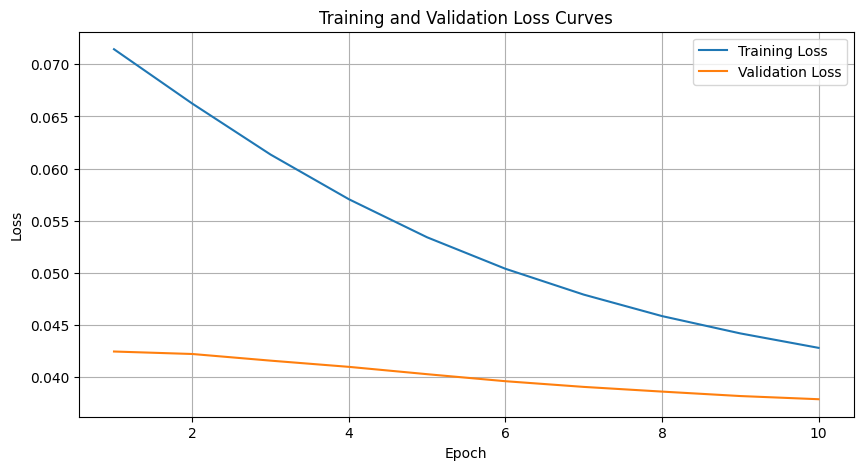

In [16]:
num_epochs = len(train_losses)  # Update to reflect the actual number of epochs trained, useful if early stopping was triggered

def smooth_curve(points, factor=0.8):
    """Smooths the curve for better visualization."""
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Optionally smooth the loss curves
train_losses_smooth = smooth_curve(train_losses)
val_losses_smooth = smooth_curve(val_losses)

plt.figure(figsize=(10, 5))  # Set the figure size for better readability
plt.plot(range(1, num_epochs + 1), train_losses_smooth, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses_smooth, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)  # Add grid
plt.legend()
plt.show()

In [17]:
# Calculate Mean Absolute Error (MAE)
with torch.no_grad():
    total_mae = 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        total_mae += torch.mean(torch.abs(outputs - targets)).item()
    mae = total_mae / len(test_loader)

print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Calculate Mean Squared Error (MSE)
with torch.no_grad():
    total_mse = 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        total_mse += torch.mean((outputs - targets) ** 2).item()
    mse = total_mse / len(test_loader)

print(f'Mean Squared Error (MSE): {mse:.4f}')


Mean Absolute Error (MAE): 0.1297
Mean Squared Error (MSE): 0.0371


In [18]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

# Initialize lists to store predictions and true values
all_predictions = []
all_targets = []

# Test the model
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        # Store predictions and true values for evaluation
        all_predictions.extend(outputs.numpy().flatten())
        # print(all_predictions)
        all_targets.extend(targets.numpy().flatten())

# Convert predictions and true values to numpy arrays
all_predictions = np.array(all_predictions)
# print(all_predictions)
all_targets = np.array(all_targets)
# print(len(all_targets))

binary_classification_threshold = 0.85
abs_difference_threshold = 0.35

# Check if the absolute difference is smaller than the threshold
abs_difference = np.abs(all_predictions - all_targets)
abs_difference_mask = abs_difference <= abs_difference_threshold

# Convert to binary classification based on threshold
binary_predictions = np.where(all_predictions >= binary_classification_threshold, 1, 0)
# print(binary_predictions)
binary_targets = np.where(all_targets >= binary_classification_threshold, 1, 0)
# print(binary_targets)

for i in range(len(binary_predictions)):
    if abs_difference_mask[i] == True:
        binary_predictions[i] = binary_targets[i]

# Calculate precision, recall, accuracy, and AUC
precision = precision_score(binary_targets, binary_predictions)
recall = recall_score(binary_targets, binary_predictions)
accuracy = accuracy_score(binary_targets, binary_predictions)
auc = roc_auc_score(binary_targets, binary_predictions)

print(f'Test Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}, AUC: {auc:.4f}')

# Calculate false alarm rate (FPR)
# False alarm rate = false positives / (false positives + true negatives)
true_negatives = np.sum((binary_targets == 0) & (binary_predictions == 0))
false_positives = np.sum((binary_targets == 0) & (binary_predictions == 1))
false_alarm_rate = false_positives / (false_positives + true_negatives)

print(false_alarm_rate)

Test Precision: 0.9466, Recall: 0.9844, Accuracy: 0.9458, AUC: 0.9036
0.17717073170731706


Confusion Matrix:
[[ 4217   908]
 [  255 16089]]


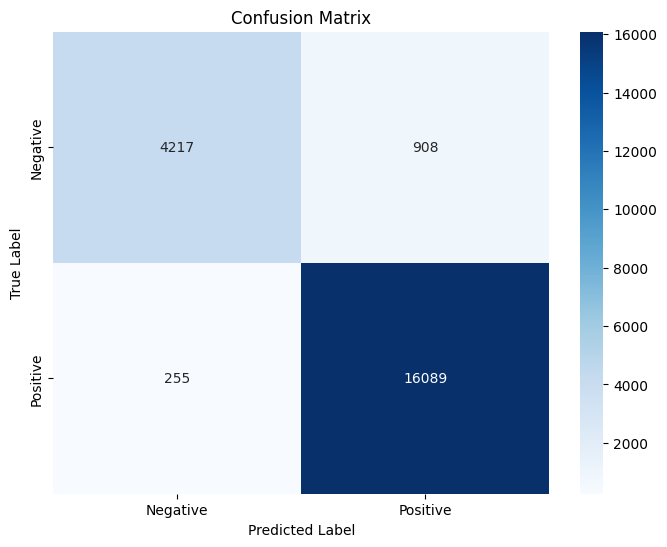

In [19]:
# Calculate and display the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(binary_targets, binary_predictions)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
import shap

# Convert PyTorch tensors to NumPy arrays
X_train_numpy = X_train_tensor.numpy()
X_test_numpy = X_test_tensor.numpy()

# Create a SHAP explainer object using KernelExplainer
explainer = shap.KernelExplainer(model, X_train_numpy)
print(1)

# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_test_numpy)
print(2)

# Plotting the SHAP values
shap.summary_plot(shap_values, X_test_numpy, feature_names=list(X_train.columns))

Provided model function fails when applied to the provided data set.


TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

# Define a threshold for binary classification
threshold = 0.8

# Convert target variable to binary labels based on the threshold
binary_y_train = np.where(y_train >= threshold, 1, 0)

# Define and train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, binary_y_train)

# Test XGBoost model
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Convert probabilities to binary predictions based on threshold
binary_predictions_xgb = np.where(y_pred_proba >= threshold, 1, 0)

# Calculate precision, recall, accuracy, and AUC for XGBoost model
precision_xgb = precision_score(binary_targets, binary_predictions_xgb)
recall_xgb = recall_score(binary_targets, binary_predictions_xgb)
accuracy_xgb = accuracy_score(binary_targets, binary_predictions_xgb)
auc_xgb = roc_auc_score(binary_targets, y_pred_proba)

# Print evaluation metrics for XGBoost model
print(f'XGBoost Test Precision: {precision_xgb:.4f}, Recall: {recall_xgb:.4f}, Accuracy: {accuracy_xgb:.4f}, AUC: {auc_xgb:.4f}')

# Define Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)

binary_y_train = np.where(y_train >= threshold, 1, 0)

# Train Random Forest model
rf_model.fit(X_train_scaled, binary_y_train)

# Test Random Forest model
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Convert probabilities to binary predictions based on threshold
binary_predictions_rf = np.where(y_pred_proba_rf >= threshold, 1, 0)

# Calculate precision, recall, accuracy, and AUC for Random Forest model
precision_rf = precision_score(binary_targets, binary_predictions_rf)
recall_rf = recall_score(binary_targets, binary_predictions_rf)
accuracy_rf = accuracy_score(binary_targets, binary_predictions_rf)
auc_rf = roc_auc_score(binary_targets, y_pred_proba_rf)

# Print evaluation metrics for Random Forest model
print(f'Random Forest Test Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}, Accuracy: {accuracy_rf:.4f}, AUC: {auc_rf:.4f}')


XGBoost Test Precision: 0.9036, Recall: 0.8010, Accuracy: 0.7707, AUC: 0.7977

Random Forest Test Precision: 0.9168, Recall: 0.7402, Accuracy: 0.7365, AUC: 0.8086

In [ ]:
# # Set option to display all columns
# pd.set_option('display.max_columns', None)

# # Set option to display all rows
# pd.set_option('display.max_rows', None)